In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 9.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving eval.json to eval.json


In [ ]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='train-complex99.json', split='train')
print(train_dataset)
eval_dataset = load_dataset('json', data_files='eval.json', split='train')
print(eval_dataset)

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['answer', 'question'],
    num_rows: 98
})


Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['question', 'answer'],
    num_rows: 9
})


In [ ]:
def formatting_func(input):
  text = f"### Question: {input['question']}\n ### Answer: {input['answer']}"
  return text

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model2 = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))


In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/98 [00:00<?, ? examples/s]

107


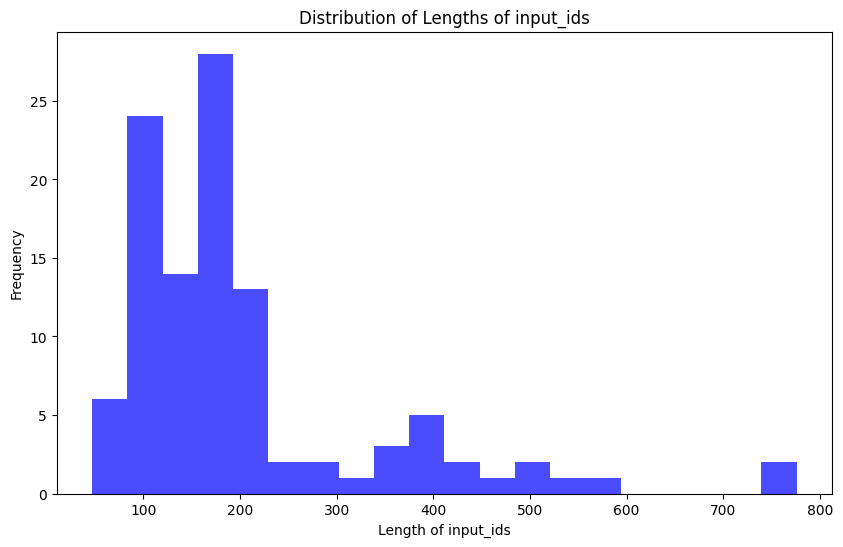

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [ ]:
max_length = 750 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/98 [00:00<?, ? examples/s]

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

In [ ]:
print(tokenized_train_dataset[1]['input_ids'])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

107


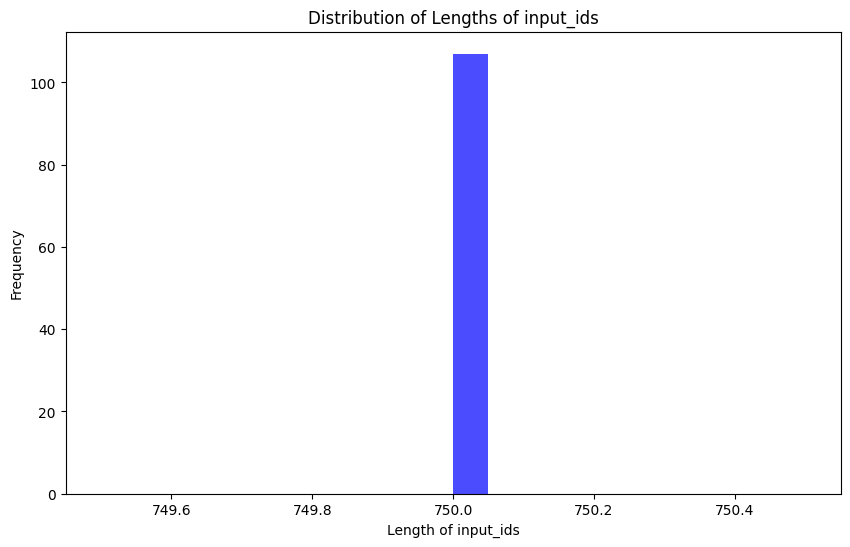

In [ ]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [ ]:
from peft import prepare_model_for_kbit_training

model2.gradient_checkpointing_enable()
model2 = prepare_model_for_kbit_training(model2)

OutOfMemoryError: CUDA out of memory. Tried to allocate 500.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 251.06 MiB is free. Process 4244 has 14.48 GiB memory in use. Of the allocated memory 14.19 GiB is allocated by PyTorch, and 154.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
print(model2)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
   

In [ ]:
from peft import LoraConfig, get_peft_model
from peft import prepare_model_for_kbit_training

model2.gradient_checkpointing_enable()
model2 = prepare_model_for_kbit_training(model2)
# only target modules on attention block
config2 = LoraConfig(
    r=256, # ola value = 32
    lora_alpha=512, # old value = 64
    target_modules=[
        "q_proj",
        #"k_proj",
        "v_proj",
        #"o_proj",
        #"gate_proj",
        #"up_proj",
        #"down_proj",
        #"lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model2 = get_peft_model(model2, config2)
print_trainable_parameters(model2)

# trainable params: 54525952 || all params: 3806597120 || trainable%: 1.432406695037903

trainable params: 54525952 || all params: 3806597120 || trainable%: 1.432406695037903


In [ ]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [ ]:
model2 = accelerator.prepare_model(model2)

In [ ]:
!pip install -q wandb -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.0 MB/s eta 0:00:00


In [ ]:
import wandb, os
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb_project = "gamaft-comparison-complex99"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

In [ ]:
import transformers
from datetime import datetime

project = "attention-blocks"
base_model_name = "mistral7b"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer2 = transformers.Trainer(
    model=model2,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=1000,
        learning_rate=3.5e-5, # Want a small lr for finetuning
        fp16=True,
        optim="paged_adamw_8bit",
        logging_steps=20,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=20,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=20,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model2.config.use_cache = False  # silence the warnings. Please re-enable for inference!

In [ ]:
trainer2.train()

wandb: Currently logged in as: phuonganhnn25-3 (7bmistral). Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
20,1.384000,1.620362
40,0.774800,1.595458
60,0.501800,1.594816
80,0.442300,1.532445
100,0.334200,1.537155
120,0.286900,1.616411
140,0.246000,1.623219
160,0.205000,1.773450
180,0.191700,1.649527
200,0.191700,1.831591


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Step,Training Loss,Validation Loss
20,1.384000,1.620362
40,0.774800,1.595458
60,0.501800,1.594816
80,0.442300,1.532445
100,0.334200,1.537155
120,0.286900,1.616411
140,0.246000,1.623219
160,0.205000,1.773450
180,0.191700,1.649527
200,0.191700,1.831591


In [ ]:
!pip install huggingface_hub

In [ ]:
!python -c "from huggingface_hub.hf_api import HfFolder; HfFolder.save_token('YOUR_TOKEN_HERE')"

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
    use_auth_token=True
)

eval_tokenizer2 = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:472: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from peft import PeftModel

ft_model1 = PeftModel.from_pretrained(base_model, "mistral7b-attention-blocks/checkpoint-100")
ft_model2 = PeftModel.from_pretrained(base_model, "mistral7b-attention-blocks/checkpoint-500")
ft_model3 = PeftModel.from_pretrained(base_model, "mistral7b-attention-blocks/checkpoint-1000")

In [ ]:
eval_prompt = " Could you provide a code snippet for me a model with two species name prey and predator: # "
model_input = eval_tokenizer2(eval_prompt, return_tensors="pt").to("cuda")

ft_model1.eval()
with torch.no_grad():
    print(eval_tokenizer2.decode(ft_model1.generate(**model_input, max_new_tokens=1000, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Could you provide a code snippet for me a model with two species name prey and predator: #  ### Prey: ### species prey { ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ##

In [ ]:
eval_prompt = " Could you provide a code snippet for me a model with two species name prey and predator: # "
model_input = eval_tokenizer2(eval_prompt, return_tensors="pt").to("cuda")

ft_model2.eval()
with torch.no_grad():
    print(eval_tokenizer2.decode(ft_model2.generate(**model_input, max_new_tokens=1000, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Could you provide a code snippet for me a model with two species name prey and predator: #  ### Prey: ### species prey { ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ##

In [ ]:
eval_prompt = " Could you provide a code snippet for me a model with two species name prey and predator: # "
model_input = eval_tokenizer2(eval_prompt, return_tensors="pt").to("cuda")

ft_model3.eval()
with torch.no_grad():
    print(eval_tokenizer2.decode(ft_model3.generate(**model_input, max_new_tokens=1000, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Could you provide a code snippet for me a model with two species name prey and predator: #  ### Prey: ### species prey { ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ##